Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')


Path

In [2]:
output_folder = "data/twitter_preprocessed/"

graph_twitter_full.csv : 
    
    - 62293412 lines
    - 12,15
    - 12,17
    - 12,18




data/twitter/retweetsranked_full.csv

    - 2332764 lines
    - 3059561715;2009-08-01 00:25:33;21172954;21926959;3059313429
    - 3096677654;2009-08-03 04:20:16;16103374;7516242;3090911707


In [47]:
df_retweets = pd.read_csv("data/twitter/retweetsranked_full.csv", 
    sep = ';', 
    #chunksize=1000, 
    header=None, )
df_retweets.columns = ["mid_rt", "date", "v", "u", "mid"]
df_retweets.drop(columns=['mid_rt', 'date'])

print("df_retweets : \n" + df_retweets.head(5).to_markdown())
print(f"shape : {df_retweets.shape}\n")


df_retweets : 
|    |     mid_rt | date                |                v |           u |         mid |
|---:|-----------:|:--------------------|-----------------:|------------:|------------:|
|  0 | 3059561715 | 2009-08-01 00:25:33 |      2.1173e+07  | 2.1927e+07  | 3.05931e+09 |
|  1 | 3096677654 | 2009-08-03 04:20:16 |      1.61034e+07 | 7.51624e+06 | 3.09091e+09 |
|  2 | 3117573474 | 2009-08-04 05:27:05 |      2.1173e+07  | 1.93294e+07 | 3.1173e+09  |
|  3 | 3131299653 | 2009-08-04 22:36:20 | 786741           | 1.51482e+07 | 3.13116e+09 |
|  4 | 3147599284 | 2009-08-05 18:04:48 |      2.1173e+07  | 2.00788e+07 | 3.14647e+09 |
shape : (2332764, 5)



In [48]:
def subsampling_twitter(n_min_cascade_per_u, n_min_cascade_per_v) :
    """
    selects the row of df_retweets where u has more than u_min_cascade_per_u cascades and same with v
    """
    n_cascades_per_u = df_retweets.groupby('u').agg({'mid' : 'count'})
    n_cascades_per_v = df_retweets.groupby('v').agg({'mid' : 'count'})

    influencers = list(n_cascades_per_u[n_cascades_per_u['mid'] > n_min_cascade_per_u].index)
    targets = list(n_cascades_per_v[n_cascades_per_v['mid'] > n_min_cascade_per_v].index)

    print(f"i = {len(influencers)}, t = {len(targets)}")

    df_labels = df_retweets[df_retweets['u'].isin(influencers)][['u','v']]
    df_labels = df_labels[df_labels['v'].isin(targets)][['u','v']]
    Au = df_labels.groupby('u').count().v
    Au.name = 'Au'
    Av = df_labels.groupby('v').count().u
    Av.name = 'Av'

    df_labels = df_labels.merge(Au, on='u')
    df_labels = df_labels.merge(Av, on='v')

    Au2v = df_labels.groupby(['u', 'v']).count().Au.reset_index()
    df_labels = df_labels.merge(Au2v, on=['u','v'])

    df_labels.columns = ['u', 'v', 'Au', 'Av', 'Au2v']
    df_labels = df_labels.drop_duplicates()
    df_labels['u'] = df_labels['u'].astype(np.int64)
    df_labels['v'] = df_labels['v'].astype(np.int64)
    return df_labels



In [49]:
def estimate_probabilities(df_labels, save=False, file_name="") : 
    """
    input : edges dataframe 
    """
    df_labels['BT'] = df_labels['Au2v'] / df_labels['Au']
    df_labels['JI'] = df_labels['Au2v'] / (df_labels['Au'] + df_labels['Av'])
    df_labels['LP'] = df_labels['Au2v'] / df_labels['Av']

    df_labels = df_labels[['u', 'v', 'BT', 'JI', 'LP']]
    df_labels = df_labels.drop_duplicates()
    print("db labels : \n" + df_labels.head(5).to_markdown())
    print(f"shape : {df_labels.shape}\n")

    if save :
        print("Saved " + file_name)
        pd.to_pickle(df_labels, output_folder+file_name)
    
    return df_labels

df_labels = subsampling_twitter(100,100)
df_labels = estimate_probabilities(df_labels, True, "labels_100_100.pkl")

i = 1837, t = 2508
db labels : 
|    |                u |          v |         BT |         JI |        LP |
|---:|-----------------:|-----------:|-----------:|-----------:|----------:|
|  0 |      1.93294e+07 | 2.1173e+07 | 0.0042735  | 0.00380228 | 0.0344828 |
|  1 |     13           | 2.1173e+07 | 0.0909091  | 0.0392157  | 0.0689655 |
|  3 | 428333           | 2.1173e+07 | 0.00131062 | 0.00126263 | 0.0344828 |
|  4 | 783214           | 2.1173e+07 | 0.0681818  | 0.0512821  | 0.206897  |
| 10 |      2.8706e+07  | 2.1173e+07 | 0.0645161  | 0.0333333  | 0.0689655 |
shape : (31649, 5)

Saved labels_100_100.pkl


In [68]:
influencers = list(df_labels.groupby('u').count().index)
targets = list(df_labels.groupby('v').count().index)
print(len(influencers), len(targets))

1828 2432


In [52]:
u_to_userids = pd.read_csv("data/weibo/weibodata/diffusion/uidlist.txt",header=None)
u_to_userids.columns = ['userid']
u_to_userids.index.name = 'uid'

In [8]:
def create_edges(users_topology) : 
    """
    Creates weibo/edges_NB_CASCADES.pkl ---> |id|u|v|
    2.4M edges for 1000 cascades
    Takes 4min to extract
    """
    
    #Speeds up operation (v in users)
    d_users = defaultdict(lambda : False)
    for user in users_topology:
        d_users[int(user)] = True

    edges_topology = []                 

    with open("data/twitter/graph_twitter_full.csv", 'r') as file :
        
        u_previous = -1
        u_in_table = False

        n_lines = 0
        
        for line in file :
            
            n_lines += 1
            # if n_lines > 10 : break
            # print(line)
            if n_lines % 17000000 == 0 :
                print(f"{n_lines//1000000}M lines processed : {len(edges_topology)} edges added")

            line = line.split(',')
            if len(line) >= 2 :
                u,v = int(line[0]), int(line[1])
                # print(u)
                if u != u_previous : 
                    u_previous = u
                    u_in_table = (d_users[u])

                if u_in_table: 
                    if d_users[v] : 
                        edges_topology.append((u,v))
             
    return edges_topology

def process_edges(edges_topology, save = False, file_name = ""):
    """
    replaces user id with the real ones 
    """
    df_edges = pd.DataFrame(edges_topology, columns=['u','v'])
    print("df_edges : \n" + df_edges.head(5).to_markdown())
    print(f"shape : {df_edges.shape}\n")

    if save :
        df_edges.to_pickle(output_folder + file_name)
    return df_edges

users = list(set(influencers).union(targets))
edges = create_edges(users)
df_edges = process_edges(edges, True, "edges_100_100.pkl")

17M lines processed : 31478 edges added
34M lines processed : 47662 edges added
51M lines processed : 60558 edges added


### Feature Engineering

In [70]:

import networkx as nx

d_edges = defaultdict(lambda : 0)
for (u,v) in zip(df_edges.u, df_edges.v) : d_edges[(u,v)] = 1

deg_out = df_edges.groupby('u').count()
d_deg_out = {u:0 for u in influencers} # some influencers will have 0 degrees
for u in deg_out.index : d_deg_out[u] = deg_out.loc[u].v

deg_in = df_edges.groupby('v').count()
d_deg_in= {v : 0 for v in targets}
for v in deg_in.index : d_deg_in[v] = deg_in.loc[v].u

g = nx.DiGraph()
g.add_nodes_from(users)
g.add_edges_from(zip(df_edges.u, df_edges.v))

pagerank = nx.pagerank(g)
pagerank = pd.DataFrame.from_dict(pagerank, orient='index')
pagerank.columns = ['pagerank']

d_2g = {u : 0 for u in influencers}
for i in influencers : 
    set_2neighboors = set()
    for n in nx.DiGraph.neighbors(g,i) : 
        set_2neighboors = set_2neighboors.union(set([n2 for n2 in nx.DiGraph.neighbors(g,n)]))
    d_2g[i] = len(set_2neighboors)
    # print(len(set_2neighboors))
df_2reachable = pd.DataFrame.from_dict(d_2g, orient='index')
# df_2reachable = df_2reachable / 2500
df_2reachable.columns = ['#2r']

In [76]:
def feature_twitter(u,v) :
    """
    i:followers_count, 'i:friends_count', 'i:statuses_count', 'i:verified', 'i:gender', 
    'i:d_out', 'i:pagerank', 'i:#2r', 
    'i:high_topic', 'i:med_topic', 'i:low_topic', 
    't:followers_count', 't:friends_count', 't:statuses_count', 't:verified', 't:gender', 
    't:d_out', 't:pagerank', 
    't:high_topic', 't:med_topic', 't:low_topic', 
    'edge'
    """
        
    return np.concatenate([np.zeros(5), 
                                        d_deg_out[u],
                                        pagerank.loc[u],
                                        d_2g[u],
                                        np.zeros(8),
                                        d_deg_in[v],
                                        pagerank.loc[v],
                                        np.zeros(3),
                                        d_edges[(u,v)]], axis = None)

feature_twitter(19329393, 21172954)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.00672351e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.00000000e+00, 2.02760823e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [83]:
d_fu = {u:[d_deg_out[u], float(pagerank.loc[u]), float(df_2reachable.loc[u])] for u in influencers}
features_influencers = pd.DataFrame.from_dict(d_fu, orient='index', columns=['deg_out', 'pagerank', '#2r'])
d_fv = {v:[d_deg_in[v], float(pagerank.loc[v])] for v in targets}
features_targets = pd.DataFrame.from_dict(d_fv, orient='index', columns=['deg_in', 'pagerank'])


In [84]:
features_influencers['deg_out'] = features_influencers['deg_out'].apply(lambda x : np.log(1 + x) / 8)
features_influencers['pagerank'] = features_influencers['pagerank'] / 0.00011
features_influencers['#2r'] = features_influencers['#2r'] / 2500
features_targets['deg_in'] = features_targets['deg_in'].apply(lambda x : np.log(1 + x) / 7)
features_targets['pagerank'] = features_targets['pagerank'] / 0.00011  

features_influencers.to_pickle(output_folder + 'features_influencers.pkl')
features_targets.to_pickle(output_folder + 'features_targets.pkl')

### PLOTS
Generating the figure of influence of minimal number of targets / cascades

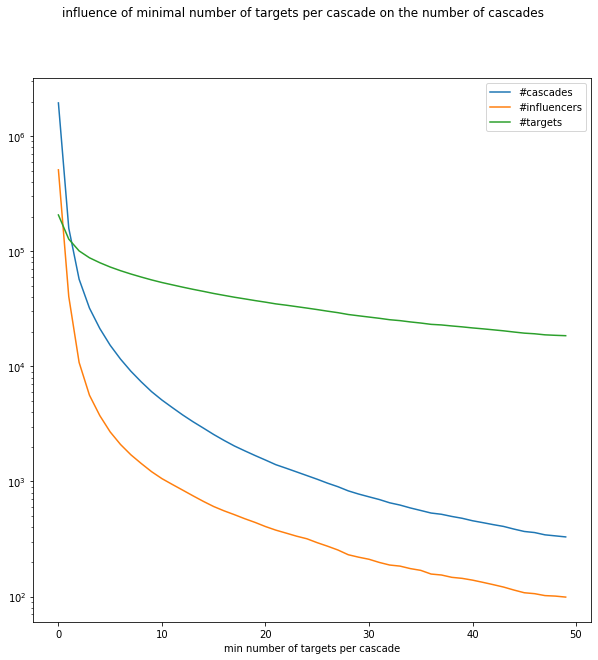

In [ ]:
n_cascades = []
n_i = []
n_t = []

for i in range(50) : 
    cascades = user_cascades[user_cascades['#reposts'] > i]
    n_i.append(cascades.groupby('u').count().shape[0])
    n_t.append(cascades.explode('vs').groupby('vs').count().shape[0])
    n_cascades.append(cascades.shape[0])

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(n_cascades, label='#cascades')
ax.plot(n_i, label = '#influencers')
ax.plot(n_t, label='#targets')
ax.set_yscale('log')
ax.set_ylabel('count')
ax.legend()
ax.set_xlabel('min number of targets per cascade')
fig.suptitle('influence of minimal number of targets per cascade on the number of cascades')
plt.show()

Cascades analysis : 

    - N_MIN_REAC | #cascades
    - 1          | 1.947M
    - 2          | 158 986
    - 3          | 57 216
    - 4          | 32 091
    - 5          | 21 337
    - 10         | 6 035
    - 15         | 2 913
    - 20         | 1 681

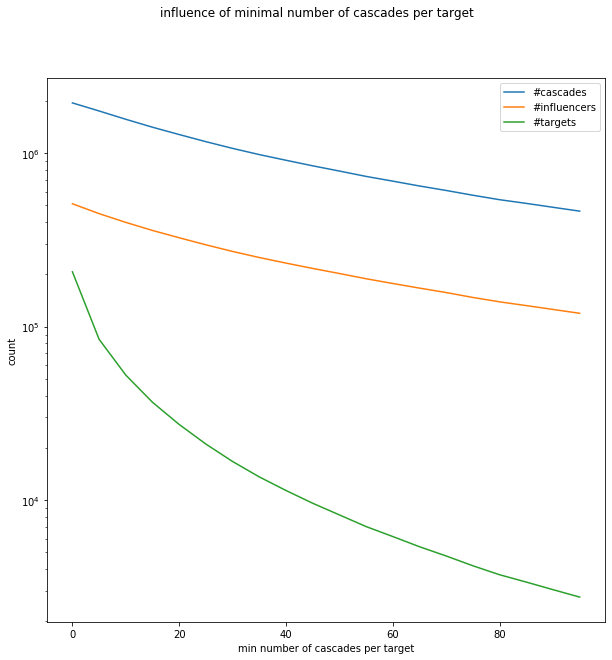

In [ ]:
ss2 = df_retweets.groupby('v').agg({"mid" : list, "date":'count','u' : list})
ss2 = ss2.reset_index()
ss2.columns = ['v', 'mids' , '#cascades', 'us']
N_MIN_REAC = 5
n_cascades = []
n_i = []
n_t = []

for i in range(0,100, 5) : 
    ss = ss2[ss2['#cascades'] > i]
    n_t.append(ss.groupby('v').count().shape[0])
    n_cascades.append(ss.explode('mids').groupby('mids').count().shape[0])
    n_i.append(ss.explode('us').groupby('us').count().shape[0])

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(range(0,100, 5),n_cascades, label='#cascades')
ax.plot(range(0,100, 5),n_i, label = '#influencers')
ax.plot(range(0,100, 5),n_t, label='#targets')
ax.set_yscale('log')
ax.set_ylabel('count')
ax.legend()
ax.set_xlabel('min number of cascades per target')
fig.suptitle('influence of minimal number of cascades per target')
plt.show()

min number 

end